In [ ]:
import os
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Limit CPU threads
tf.config.threading.set_inter_op_parallelism_threads(2)
tf.config.threading.set_intra_op_parallelism_threads(2)
version="swish-rmsprop"

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
import sys

print("Python version")
print(sys.version)
print("Version info")
print(sys.version_info)

Python version
3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
Version info
sys.version_info(major=3, minor=7, micro=12, releaselevel='final', serial=0)


In [4]:
def define_paths(data_dir):
    
    filepaths = []  # List to store full file paths.
    labels = []     # List to store labels corresponding to each file.

    # List all top-level directories in the given data directory.
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        
        # List all second-level directories within the current top-level folder.
        label_folders = os.listdir(foldpath)
        for label_folder in label_folders:
            label_folder_path = os.path.join(foldpath, label_folder)
            
            # List all files within the current label folder.
            files_in_folder = os.listdir(label_folder_path)
            for file_name in files_in_folder:
                # Build the full file path.
                file_path = os.path.join(label_folder_path, file_name)
                filepaths.append(file_path)
                
                # Use the name of the label folder as the file's label.
                labels.append(label_folder)

    return filepaths, labels


def define_df(file_list, label_list):
    
    # Create a pandas Series for file paths and assign a column name.
    file_series = pd.Series(file_list, name='filepaths')
    
    # Create a pandas Series for labels and assign a column name.
    label_series = pd.Series(label_list, name='labels')
    
    # Concatenate the two Series into a DataFrame along columns.
    return pd.concat([file_series, label_series], axis=1)


def create_df(data_dir):
    
    # Step 1: Retrieve file paths and corresponding labels from the directory structure.
    file_list, label_list = define_paths(data_dir)
    
    # Step 2: Create a DataFrame combining file paths and labels.
    df = define_df(file_list, label_list)
    
    # Step 3: Split the data into training (70%) and a temporary set (30%).
    # Use stratification to preserve the label distribution in the training set.
    train_df, temp_df = train_test_split(
        df,
        train_size=0.7,
        shuffle=True,
        random_state=123,
        stratify=df['labels']
    )
    
    # Step 4: Split the temporary set equally into validation (15%) and test (15%) sets.
    # Again, stratify based on labels to maintain consistent class distributions.
    valid_df, test_df = train_test_split(
        temp_df,
        train_size=0.5,
        shuffle=True,
        random_state=123,
        stratify=temp_df['labels']
    )

    return train_df, valid_df, test_df

In [5]:
def create_model_data (train_df, valid_df, test_df, batch_size):

    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [6]:
def show_images(gen):

    # Retrieve the mapping from class names to their numerical indices.
    # Example: {'cat': 0, 'dog': 1}
    g_dict = gen.class_indices
 
    # Extract a list of class names (keys of the dictionary).
    classes = list(g_dict.keys())

    # Obtain one batch of images and labels from the generator.
    images, labels = next(gen)

    # Determine the number of samples in the batch.
    batch_length = len(labels)

    # Limit the number of images to display to 25 (or fewer if the batch is smaller).
    sample_count = min(batch_length, 25)

    # Create a matplotlib figure with a large size to accommodate multiple subplots.
    plt.figure(figsize=(20, 20))

    # Loop over the selected number of images.
    for i in range(sample_count):
        # Create a subplot in a 5x5 grid. The index is shifted by 1 because subplot indexing starts at 1.
        plt.subplot(5, 5, i + 1)

        # Normalize the image pixel values to [0, 1] for display purposes.
        # This assumes that the original pixel values are in the range [0, 255].
        image = images[i] / 255.0

        # Display the image.
        plt.imshow(image)

        # Find the index of the class label with the highest probability from the one-hot encoded vector.
        label_index = np.argmax(labels[i])

        # Retrieve the class name corresponding to the label index.
        class_name = classes[label_index]

        # Set the title of the subplot to the class name with blue text.
        plt.title(class_name, color='blue', fontsize=12)

        # Remove axis ticks for a cleaner look.
        plt.axis('off')

    # Render the complete figure with all subplots.
    plt.savefig('grid.eps', format='eps')
    plt.show()

In [7]:
def plot_label_count(df, plot_title):
    
    # Calculate the count of each unique label.
    vcounts = df['labels'].value_counts()
    
    # Extract label names and their corresponding counts.
    labels = vcounts.keys().tolist()  # List of unique label names.
    values = vcounts.tolist()           # List of counts for each label.
    
    # Determine the total number of unique labels.
    lcount = len(labels)

    # If the number of labels exceeds 55, do not produce a plot.
    if lcount > 55:
        print('The number of labels is > 55, no plot will be produced')
    else:
        # Generate the bar plot for label counts.
        plot_labels(lcount, labels, values, plot_title)


def plot_labels(lcount, labels, values, plot_title):
   
    # Calculate the figure width based on the number of labels.
    # Multiply the number of labels by 4 to scale the width, but cap the width at 20.
    width = lcount * 4
    width = np.min([width, 20])

    # Create a new figure with the computed width and a fixed height.
    plt.figure(figsize=(width, 5))

    # Define text styling for the axis labels.
    text_style = {'family': 'serif', 'color': 'blue', 'size': 25}

    # Generate a bar plot with the labels on the x-axis and their counts on the y-axis.
    sns.barplot(x=labels, y=values)

    # Set the title of the plot.
    plt.title(f'Images per Label in {plot_title} data', fontsize=24, color='blue')
    
    # Rotate the x-axis labels by 90 degrees for clarity and set font sizes.
    plt.xticks(rotation=90, fontsize=18)
    plt.yticks(fontsize=18)
    
    # Label the x-axis and y-axis.
    plt.xlabel('CLASS', fontdict=text_style)
    plt.ylabel('IMAGE COUNT', fontdict=text_style)

    # Choose the rotation of the text annotations based on the number of labels.
    rotation = 'vertical' if lcount >= 8 else 'horizontal'
    
    # Annotate each bar with its corresponding count.
    for i in range(lcount):
        # Position the count text at half the height of the bar for visual balance.
        plt.text(i, values[i] / 2, str(values[i]), fontsize=12,
                 rotation=rotation, color='yellow', ha='center')

    # Display the final plot.
    plt.show()

In [8]:
def plot_training(hist):
   
    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(borderpad=1.5)

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right', borderpad=2)

    plt.tight_layout()
    plt.savefig('plots-'+version+'.eps', transparent=True, format='eps')
    plt.show()

In [9]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):

	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

In [ ]:
data_dir = 'data/training_data'

try:
    # Get splitted data
    train_df, valid_df, test_df = create_df(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.


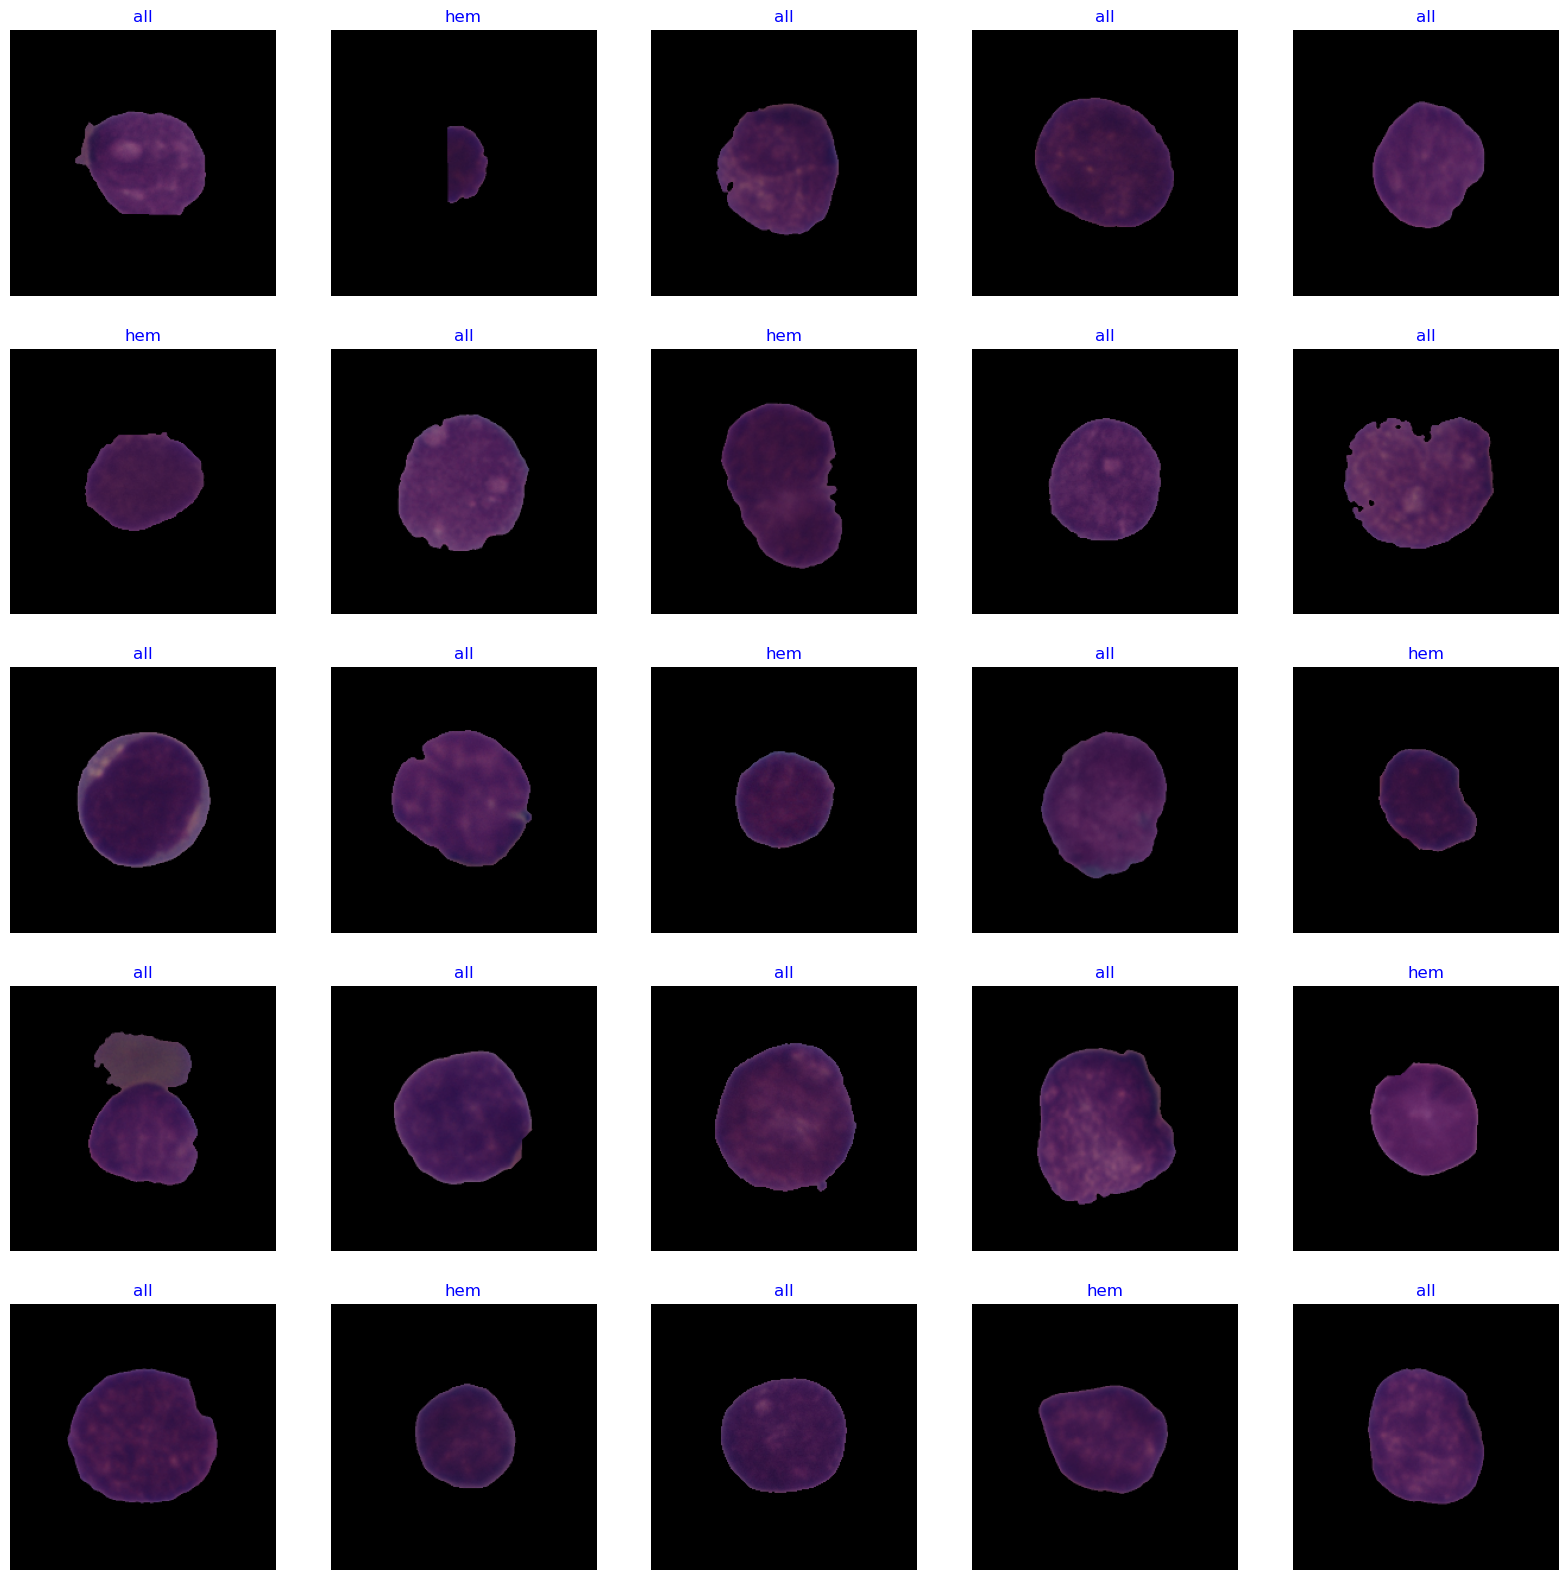

In [11]:
show_images(train_gen)

In [13]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

base_model = tf.keras.applications.EfficientNetV2B3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'avg')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'swish'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(RMSprop(learning_rate=0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

52606240/52606240 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 1536)             12930622  
 al)                                                             
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                         

In [14]:
batch_size = 40   # set batch size for training
epochs = 30 # number of all epochs in training
patience = 2   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [
           tf.keras.callbacks.EarlyStopping(
           monitor='val_loss',
           patience=stop_patience,
           #min_delta=threshold,
           #start_from_epoch=10,
           restore_best_weights=True
       ),
       tf.keras.callbacks.ReduceLROnPlateau(
           monitor='val_loss',
           factor=factor,
           patience=patience//2
       ),
       tf.keras.callbacks.TensorBoard(
           log_dir='logs',
           histogram_freq=1
       )
            ]

In [17]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= True)

Epoch 1/30
187/187 [==============================] - 75s 396ms/step - loss: 0.7702 - accuracy: 0.8251 - val_loss: 0.5092 - val_accuracy: 0.8249 - lr: 0.0010
Epoch 2/30
187/187 [==============================] - 53s 283ms/step - loss: 0.3986 - accuracy: 0.8825 - val_loss: 0.8549 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 3/30
187/187 [==============================] - 53s 284ms/step - loss: 0.2945 - accuracy: 0.9132 - val_loss: 0.2635 - val_accuracy: 0.9225 - lr: 5.0000e-04
Epoch 4/30
187/187 [==============================] - 53s 282ms/step - loss: 0.2488 - accuracy: 0.9346 - val_loss: 0.2391 - val_accuracy: 0.9287 - lr: 5.0000e-04
Epoch 5/30
187/187 [==============================] - 53s 281ms/step - loss: 0.2126 - accuracy: 0.9440 - val_loss: 0.2249 - val_accuracy: 0.9400 - lr: 5.0000e-04
Epoch 6/30
187/187 [==============================] - 53s 283ms/step - loss: 0.1924 - accuracy: 0.9520 - val_loss: 0.2993 - val_accuracy: 0.9012 - lr: 5.0000e-04
Epoch 7/30
187/187 [================

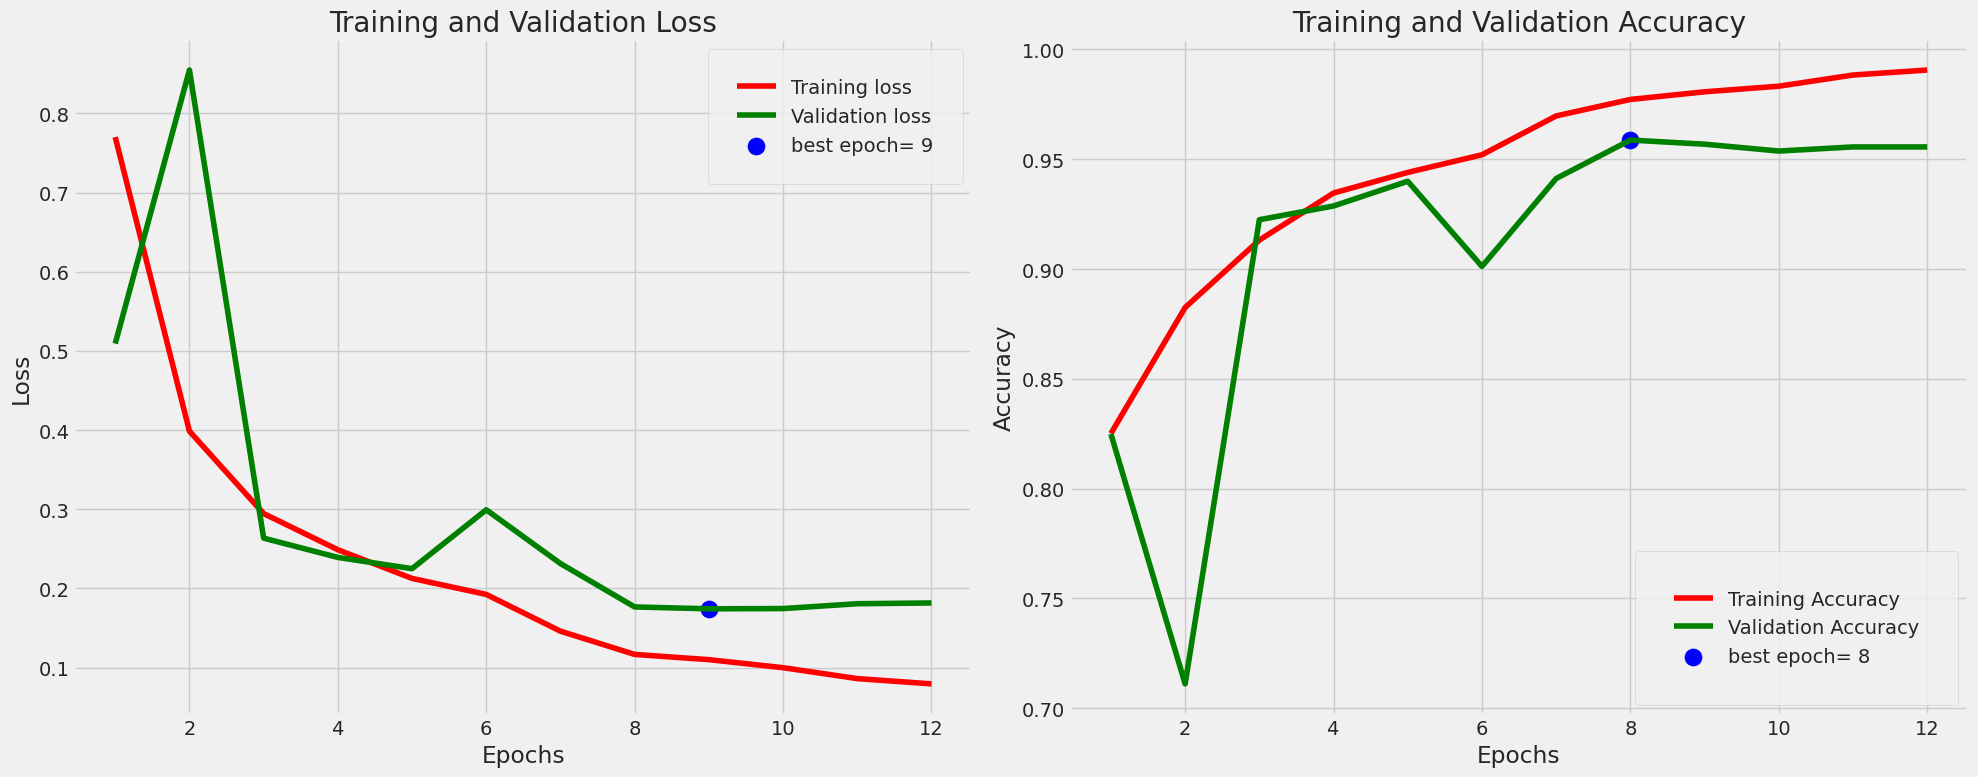

In [19]:
plot_training(history)

In [20]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

20/20 [==============================] - 13s 628ms/step - loss: 0.1576 - accuracy: 0.9631
Train Loss:  0.07054673135280609
Train Accuracy:  0.9937499761581421
--------------------
Validation Loss:  0.17752675712108612
Validation Accuracy:  0.956250011920929
--------------------
Test Loss:  0.1576267033815384
Test Accuracy:  0.9631249904632568


In [21]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[0 0 0 ... 0 1 0]


Confusion Matrix, Without Normalization
[[1066   25]
 [  34  475]]


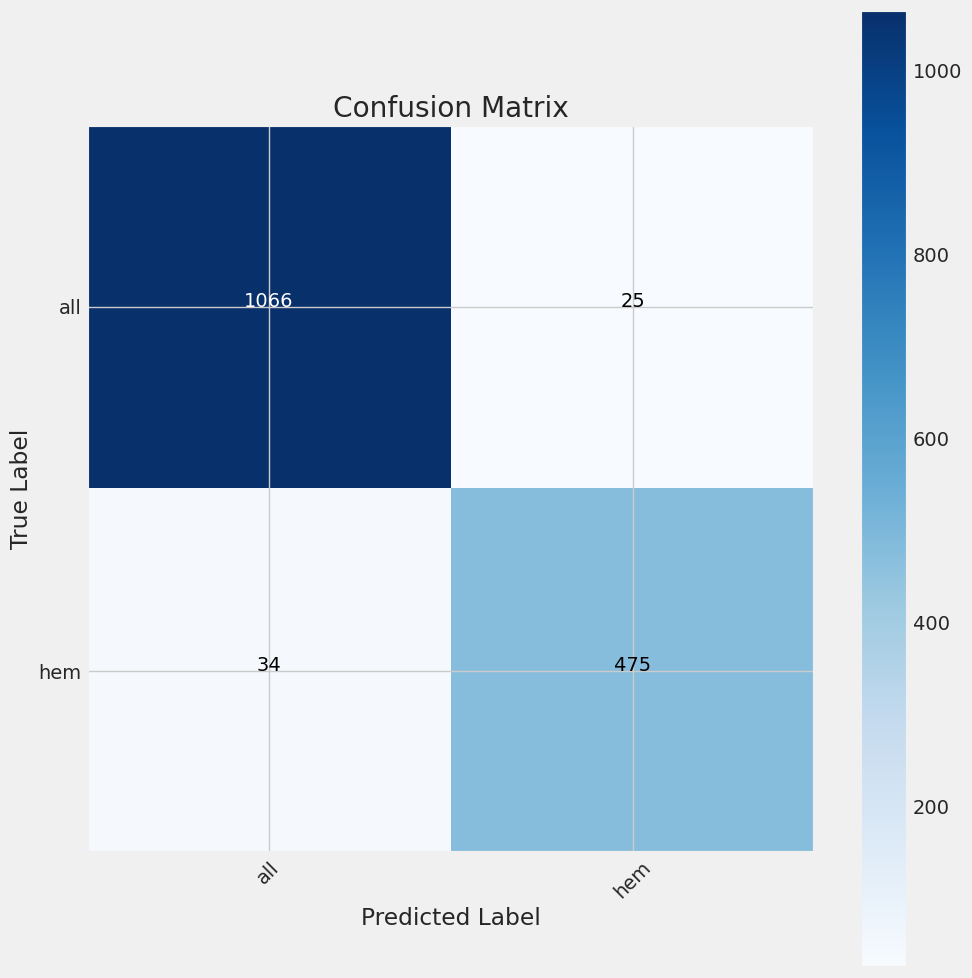

              precision    recall  f1-score   support

         all       0.97      0.98      0.97      1091
         hem       0.95      0.93      0.94       509

    accuracy                           0.96      1600
   macro avg       0.96      0.96      0.96      1600
weighted avg       0.96      0.96      0.96      1600



In [22]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')
plt.savefig('conf-'+version+'.png', transparent=True)
plt.show()

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

In [23]:
model_name = model.input_names[0][:-6]
subject = "Leukemia detection"
acc = test_score[1] * 100
save_path = ''


# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

model was saved as efficientnetv2-b3-Leukemia detection-96.31.h5
weights were saved as efficientnetv2-b3-Leukemia detection-weights.h5


In [24]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as Leukemia detection-class_dict.csv


Input image shape is  (450, 450, 3)


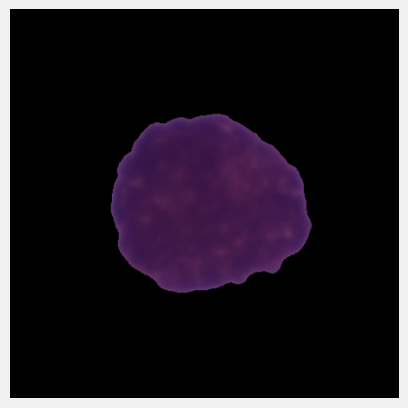

In [ ]:
img_path=r'data/validation_data/C-NMC_test_prelim_phase_data/94.bmp'
img=plt.imread(img_path)
print ('Input image shape is ',img.shape)
plt.axis('off')
imshow(img)

Input image shape is  (450, 450, 3)
the resized image has shape  (224, 224, 3)
image shape after expanding dimensions is  (1, 224, 224, 3)
1/1 [==============================] - 0s 33ms/step
the shape of prediction is  (1, 2)
the image is predicted as being hem with a probability of  98.25 %


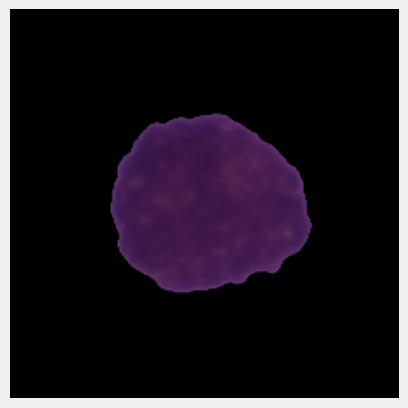

In [46]:
img=plt.imread(img_path)
print ('Input image shape is ', img.shape)
img=cv2.resize(img, (224,224)) # in earlier code img_size=(224,224) was used for training the model
print ('the resized image has shape ', img.shape)
plt.axis('off')
plt.imshow(img)

img=np.expand_dims(img, axis=0)
print ('image shape after expanding dimensions is ',img.shape)
pred=model.predict(img)
print ('the shape of prediction is ', pred.shape)

index=np.argmax(pred[0])
klass=classes[index]
probability=pred[0][index]*100
print(f'the image is predicted as being {klass} with a probability of {probability:6.2f} %')